# This notebook compares ICESat-2 ATL11 to MERRA-2

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import glob
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats


import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr
from scipy import interpolate

# Open ATL11 file

In [2]:
# Open processed file (note that region 11 includes data closer to the pole)
src_path = "../data/pt1_ATL11_081111_0309_003_01.nc" # Option 1, low SNR
# src_path = "../data/pt1_ATL11_042310_0309_003_01.nc" # Option 2, high SNR
ds_ATL11 = xr.open_dataset(src_path)
ds_ATL11

<xarray.Dataset>
Dimensions:                  (cycle: 7, x: 40584, y: 40584)
Coordinates:
  * y                        (y) float64 -2.304e+05 -2.304e+05 ... 5.98e+05
  * cycle                    (cycle) int64 1 2 3 4 5 6 7
  * x                        (x) float64 1.176e+06 1.176e+06 ... -1.038e+06
Data variables:
    Height                   (y, cycle) float32 ...
    Height_Sigma             (y, cycle) float32 ...
    Height_Sigma_Systematic  (y, cycle) float32 ...
    Time                     (y, cycle) float64 ...

# Get X and Y in Lat/lon

In [3]:
# Convert x/y to lat lonin epsg3031
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(3031) # WGS-84
tgt.ImportFromEPSG(4326) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
tgt_lon = np.zeros(len(ds_ATL11['x'])); tgt_lon[:] = np.nan
tgt_lat = np.zeros(len(ds_ATL11['y'])); tgt_lat[:] = np.nan

# Perform transformation
for j in range(0, len(ds_ATL11['x'])):
    coords = transform.TransformPoint(float(ds_ATL11['x'][j].values), float(ds_ATL11['y'][j].values))
    tgt_lat[j], tgt_lon[j] = coords[0:2]

tgt_y = xr.DataArray(ds_ATL11['y'].values, dims="points")
tgt_x = xr.DataArray(ds_ATL11['x'].values, dims="points")
tgt_lat = xr.DataArray(tgt_lat, dims="points")
tgt_lon = xr.DataArray(tgt_lon, dims="points")

# Make Map

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


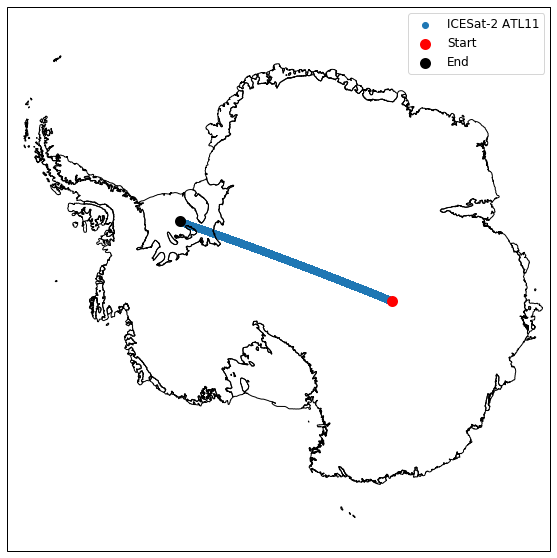

In [4]:
# Map
# Generate figure 
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -65, -90), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Plot ICESat-2
plt.scatter(ds_ATL11['x'], ds_ATL11['y'], transform=crs_epsg, label='ICESat-2 ATL11')

# Plot start and end
plt.scatter(ds_ATL11['x'][0], ds_ATL11['y'][0], c='r', linewidth=5, transform=crs_epsg, label='Start')
plt.scatter(ds_ATL11['x'][-1], ds_ATL11['y'][-1], c='k', linewidth=5, transform=crs_epsg, label='End')
plt.legend(fontsize=12)

# Plot observed change in height

In [5]:
# Calculate distance along track
def calc_dat(ds_ATL11):
    
    distance = np.sqrt((ds_ATL11['x'][-1] - ds_ATL11['x'][0])**2 + (ds_ATL11['y'][-1] - ds_ATL11['y'][0])**2)
    dat = np.linspace(0, distance, len(ds_ATL11['x']))
    dat = dat / 1000
    
    return dat

In [6]:
def get_M2_smb(t0, tf):
    '''
    Calculate the MERRA-2 SMB
    '''
    ds = xr.open_dataset("/scratch/summit/erke2265/surface-height-change/data/M2_1980-2020_daily_SMB.nc")
    ind0 = ds.indexes["time"].get_loc(t0,  method="nearest")
    indf = ds.indexes["time"].get_loc(tf,  method="nearest")
    smb = ds["__xarray_dataarray_variable__"][ind0:indf,:,:]#.sum(dim='time')
    
    return smb

In [7]:
M2_SMB_climate = xr.open_dataset("/scratch/summit/erke2265/surface-height-change/data/M2_1980-2020_daily_SMB.nc")
M2_mean_annual_SMB = M2_SMB_climate["__xarray_dataarray_variable__"].sum(dim='time') / (2020 - 1980 + 1)
M2_RF = xr.open_dataset("/pl/active/nasa_smb/Data/RF_Snow_Red_prelim.nc")

def get_RF_M2(tgt_lat, tgt_lon, tgt_x, tgt_y, M2_mean_annual_SMB, M2_RF):
    
    # M2 SMB climatology
    M2_transect = M2_mean_annual_SMB.sel(lat=tgt_lat, lon=tgt_lon, method='nearest')
    
    # RF SMB perturbation
    RF_transect = M2_RF['IS2_opt'].sel(x=tgt_x, y=tgt_y, method='nearest')
    
    # Get perturbation ratio
    RF_ratio = (RF_transect + M2_transect) / M2_transect
    return RF_ratio

In [8]:
# 1 km interpolation. First interpolate to 10 m, then 1 km
def interpolate_1km(x_src, y_src):
    
    # Linear interpolation to 10 m
    f = interpolate.interp1d(x_src, y_src, kind='linear')
    x_tgt  = np.arange(0, x_src[-1], 0.01)
    y_tgt = f(x_tgt)
    
    # Transform data from 10 m to 1 km using a convulution of the nearest 100 data points
    n_kernal = 100
    x_tgt  = np.convolve(x_tgt, np.ones(n_kernal)/n_kernal, mode='valid')[::n_kernal]
    y_tgt = np.convolve(y_tgt, np.ones(n_kernal)/n_kernal, mode='valid')[::n_kernal]
    
    return x_tgt, y_tgt

R^2 = 0.44812839723526837
p = 3.806094174616455e-239

R^2 = 0.37892557206254357
p = 4.6020888655781224e-184

R^2 = 0.2659607751282598
p = 3.3856235074207507e-128

R^2 = 0.6410748575628104
p = 0.0

R^2 = 0.3006983137540361
p = 5.266216851332313e-143

R^2 = 0.022642095108037125
p = 3.654893144544884e-10

R^2 = 0.0020466497641792544
p = 0.05254199449724884

R^2 = 0.3059394287808677
p = 3.3520836191983126e-136

R^2 = 0.021571397598808537
p = 5.174960036768188e-10

R^2 = 0.07936433457463668
p = 1.8193304804201764e-33

R^2 = 0.25974336338628695
p = 6.569133266689275e-106



/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


R^2 = 0.005283386302424984
p = 0.0027427798479707235



/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


R^2 = 0.5342860987842084
p = 9.892876874705749e-286



/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


R^2 = 0.06172442631570284
p = 6.185937797986833e-27



/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


R^2 = 0.09347658905684798
p = 5.91027125254559e-37



/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


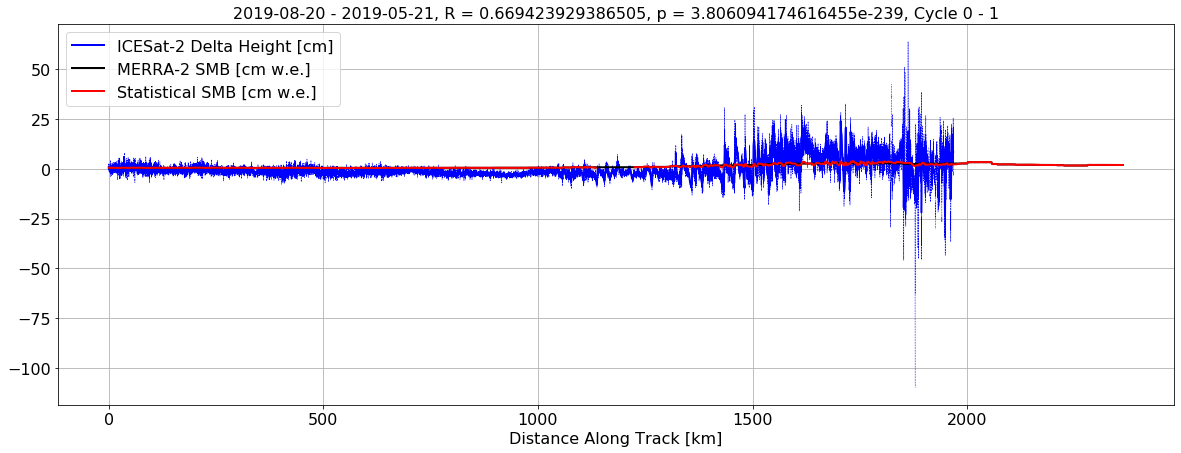

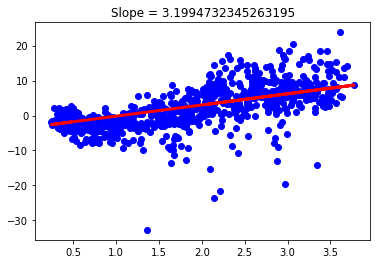

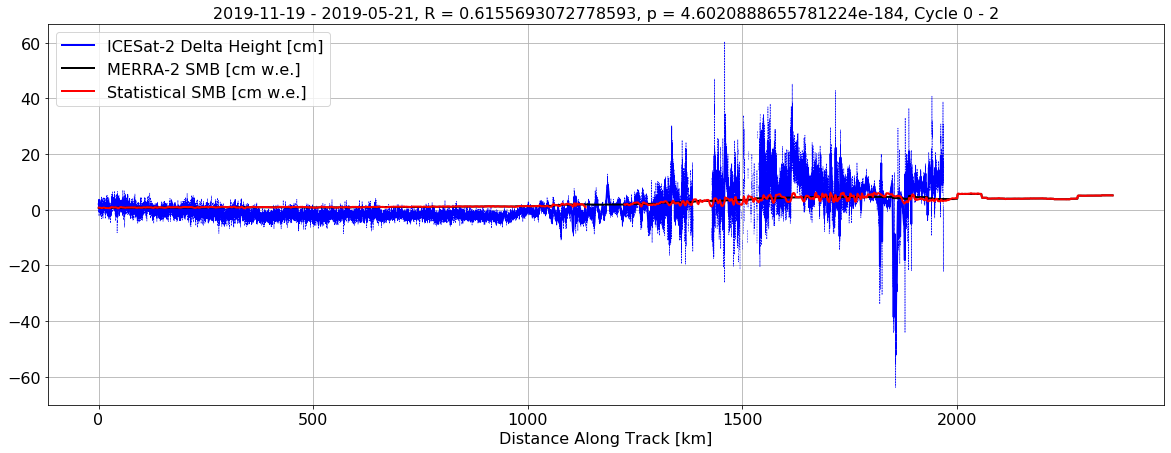

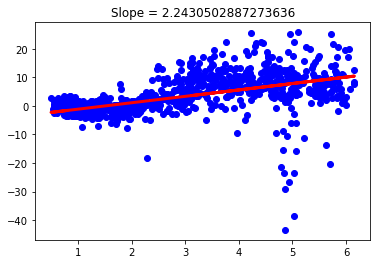

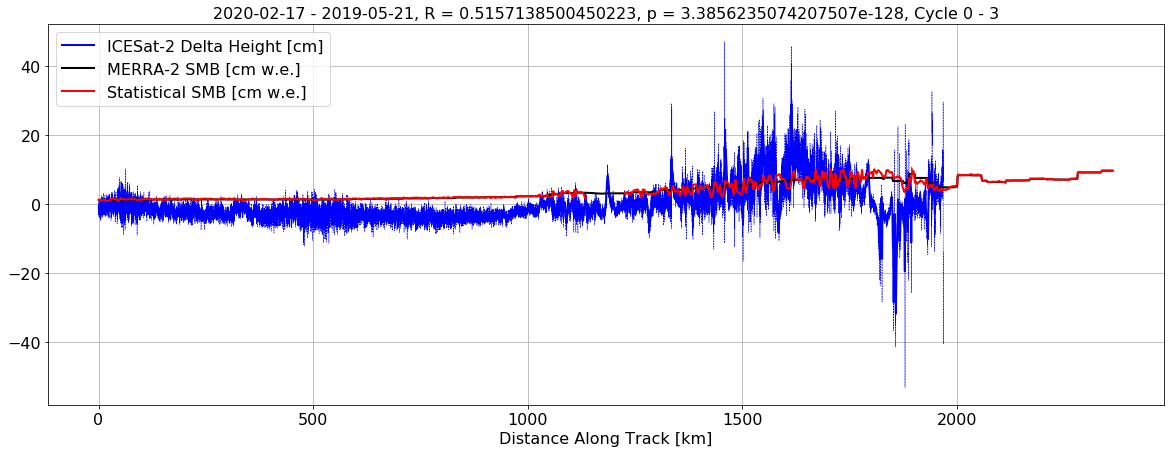

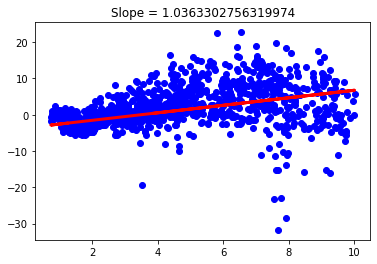

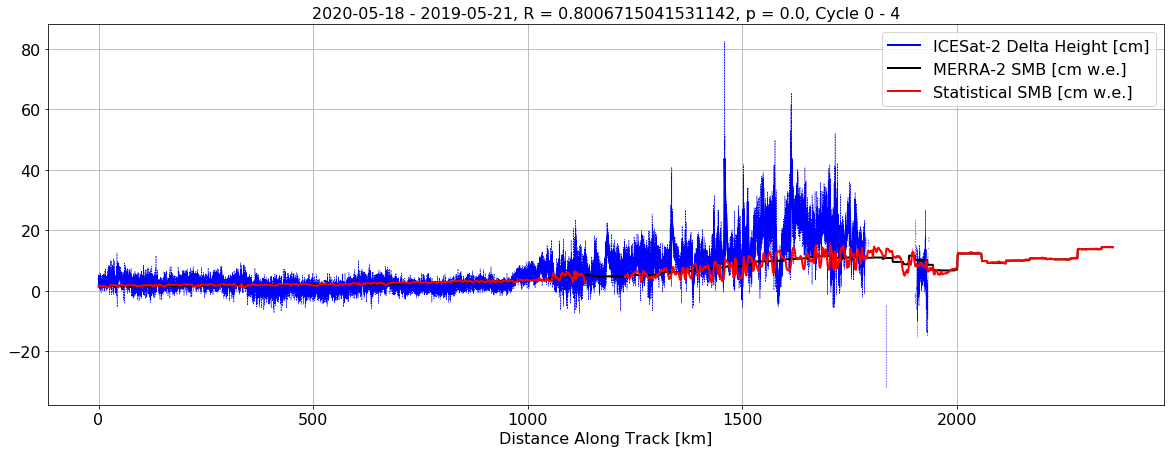

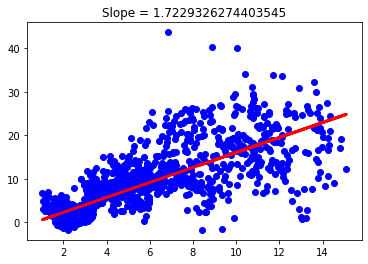

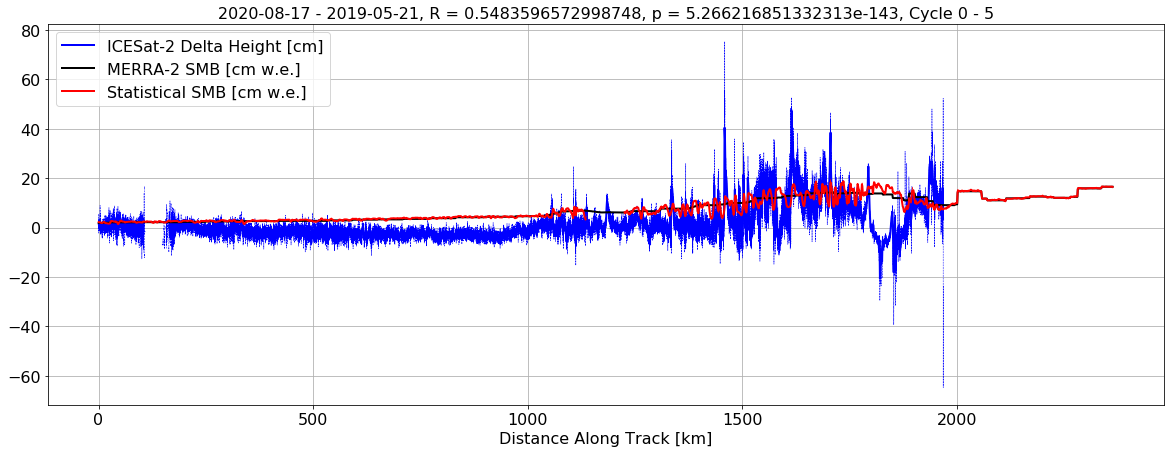

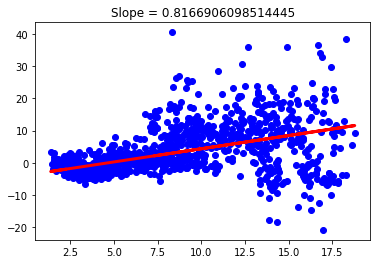

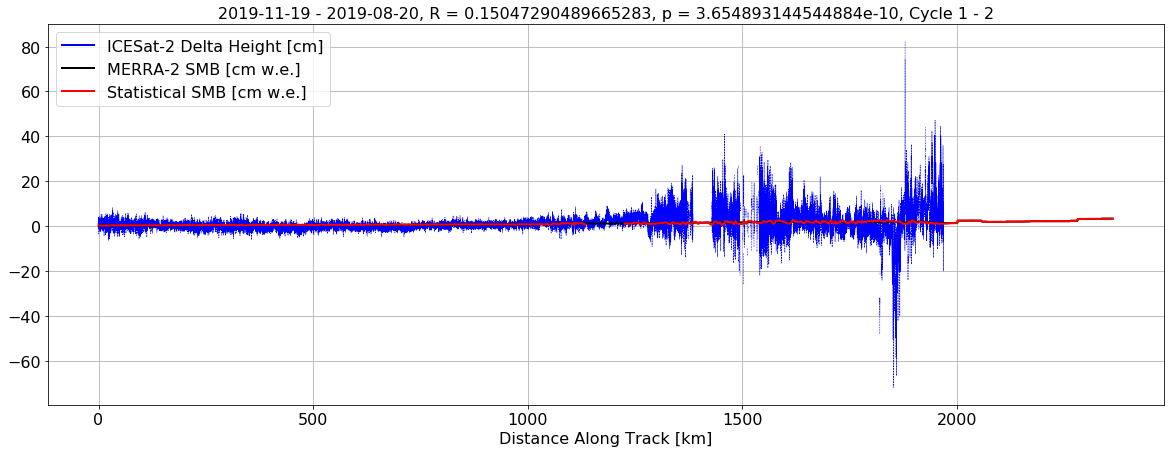

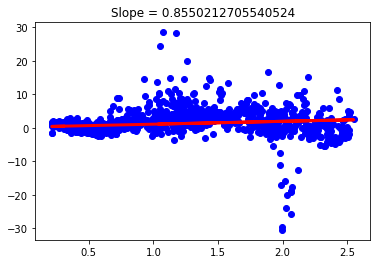

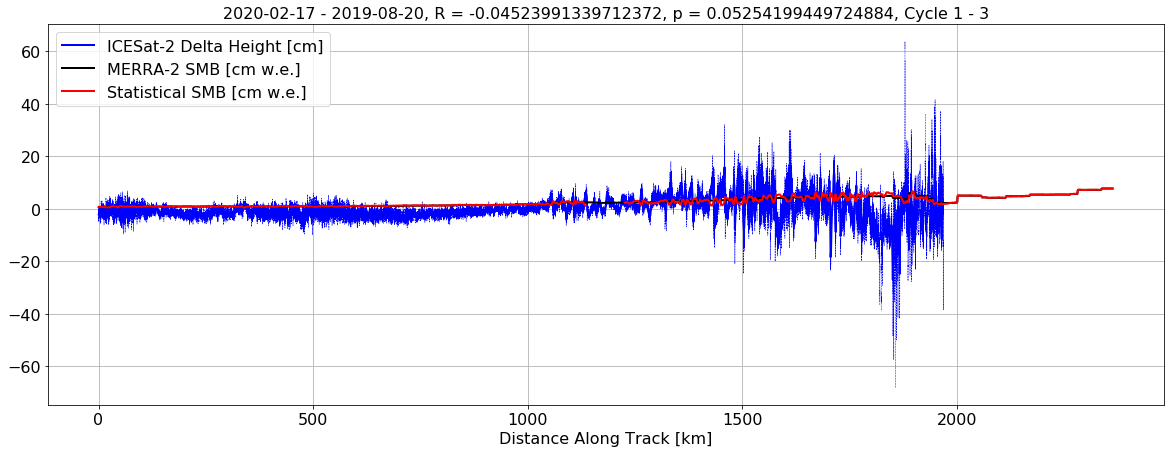

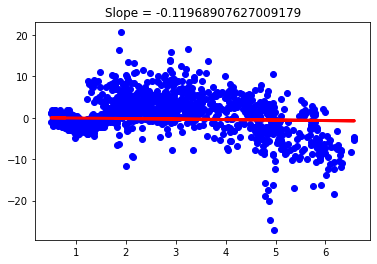

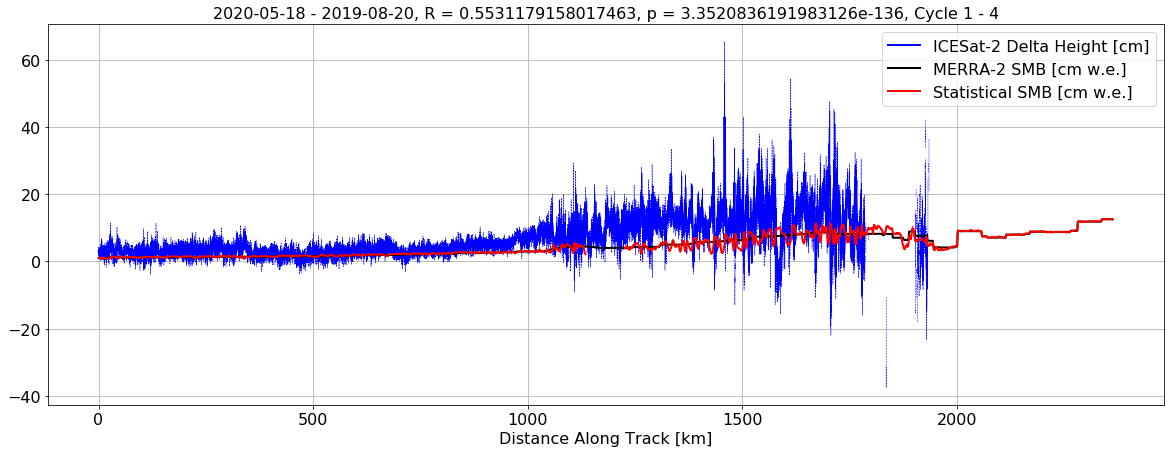

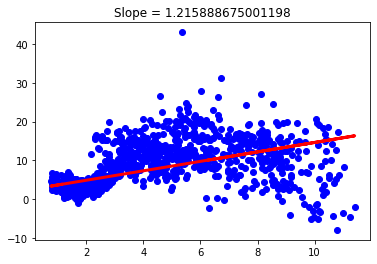

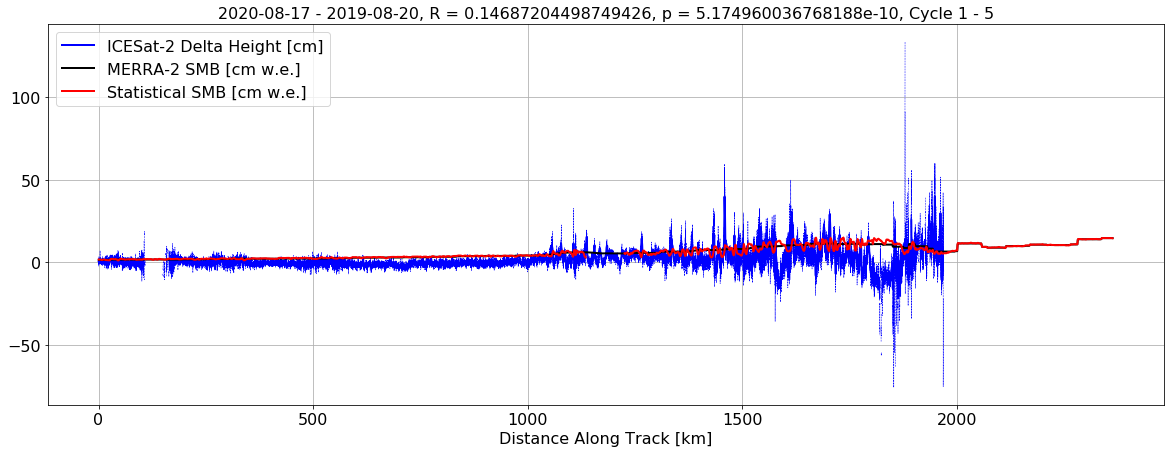

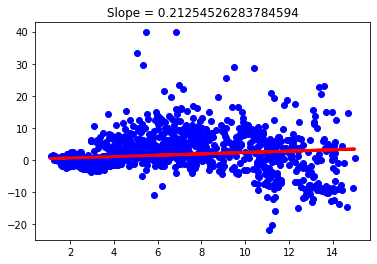

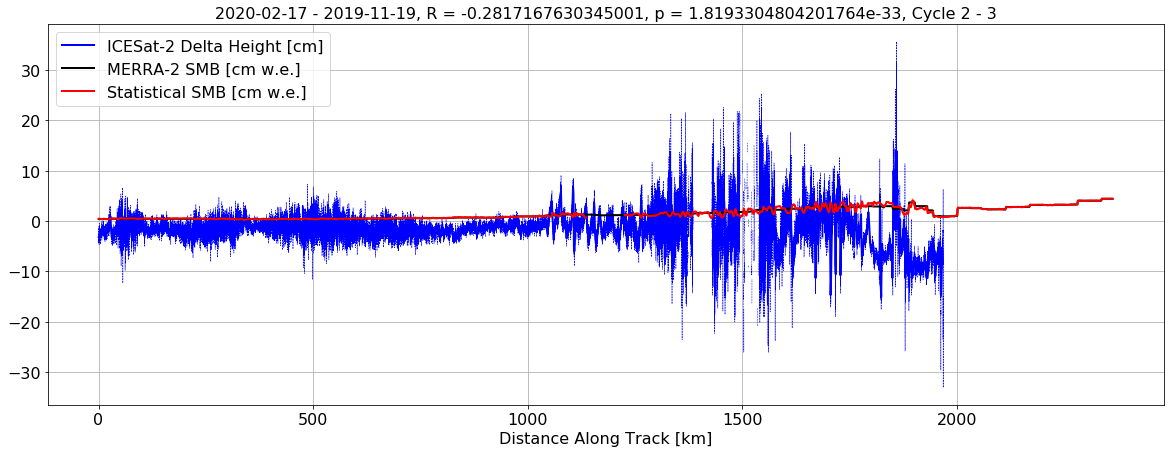

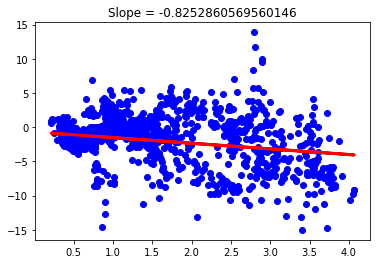

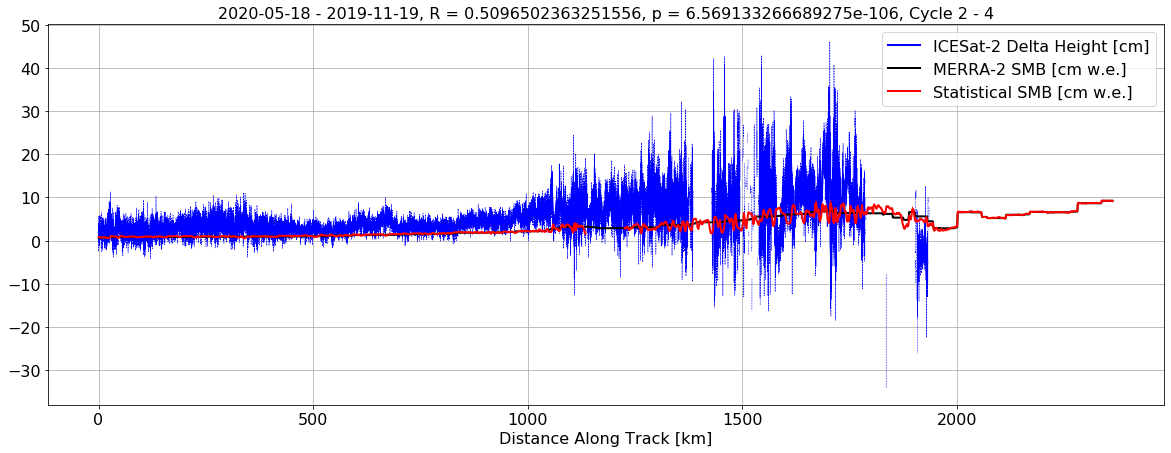

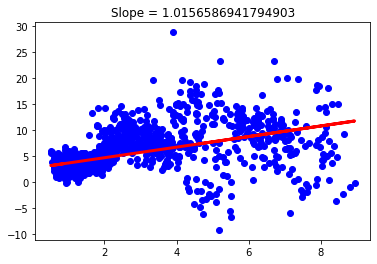

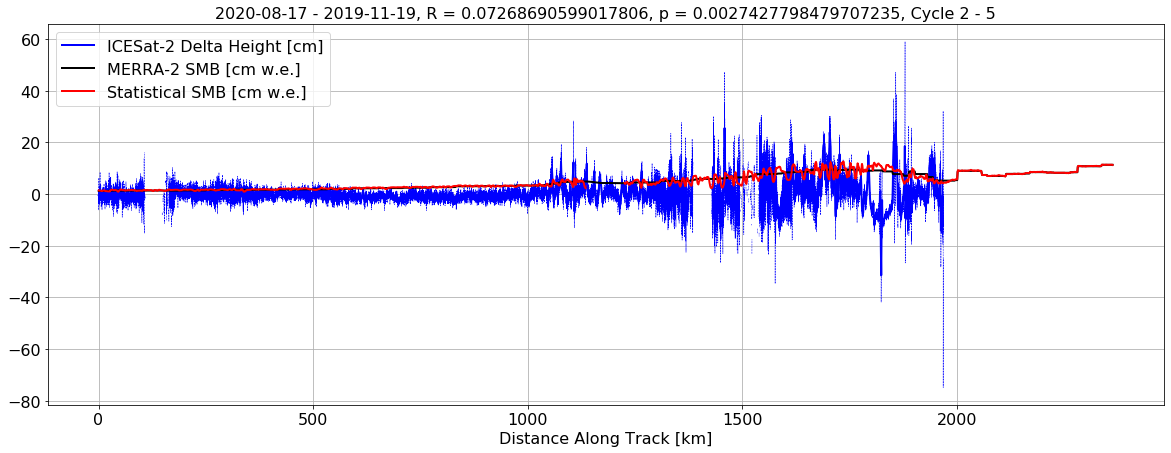

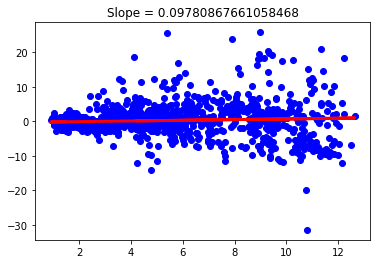

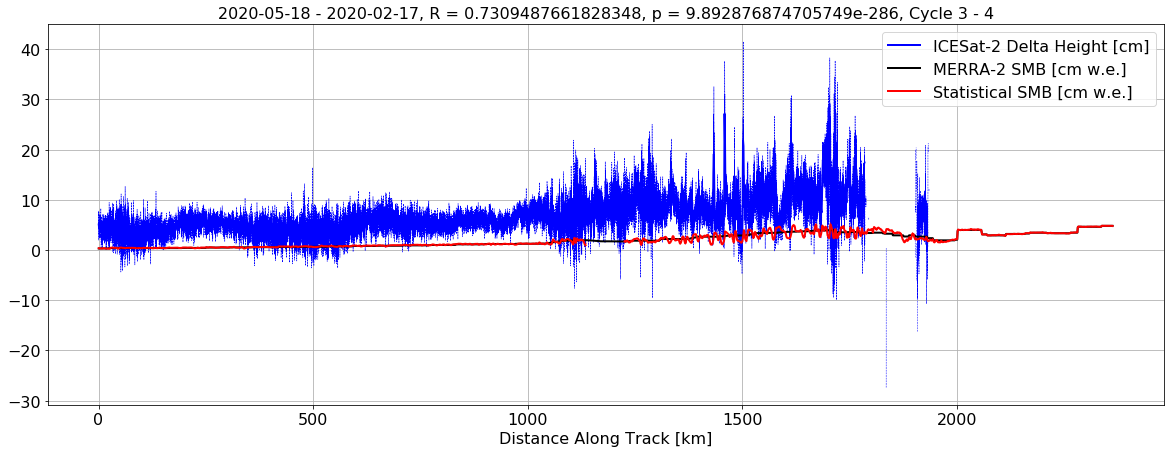

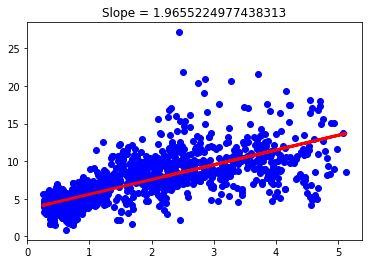

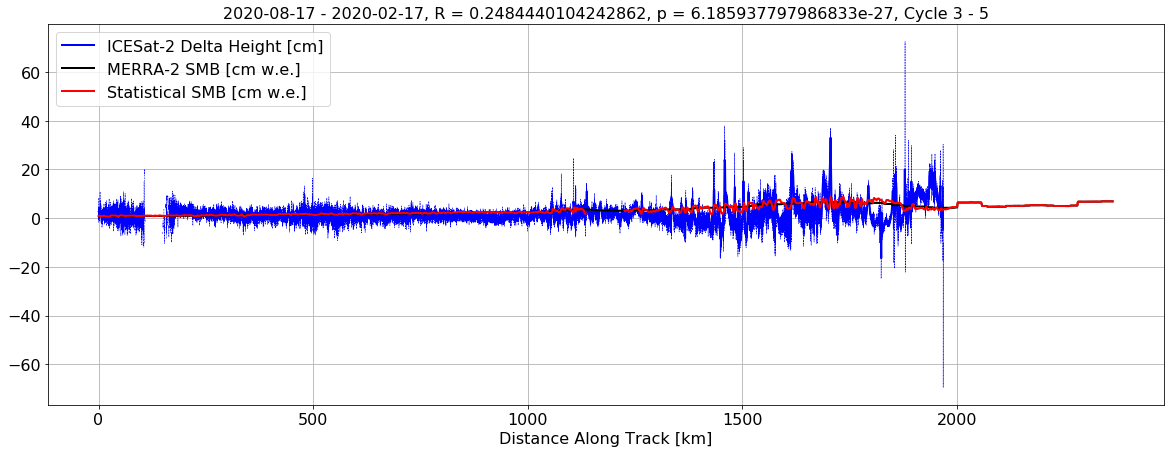

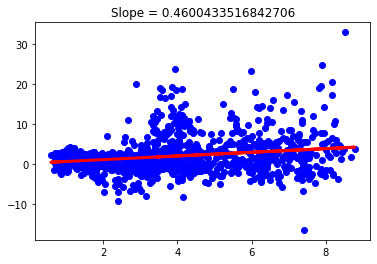

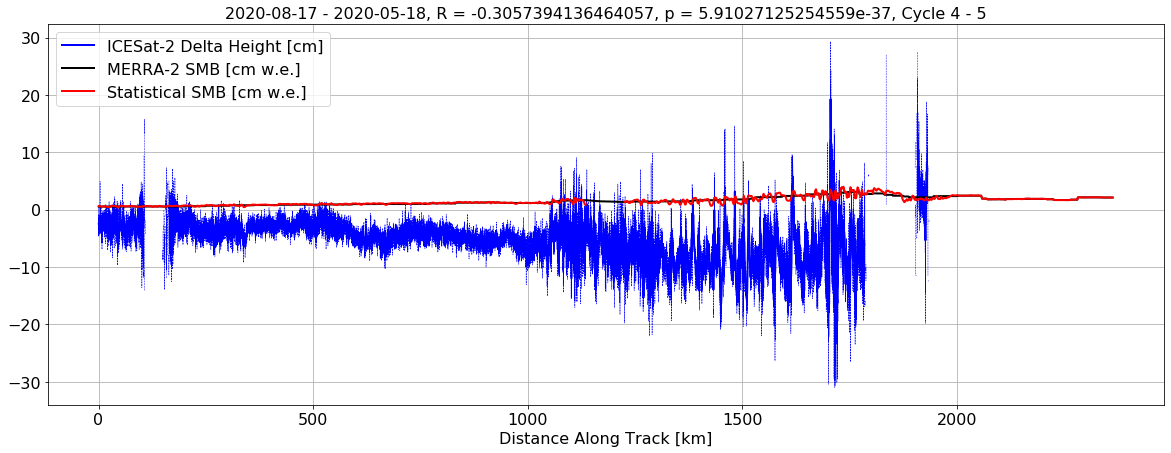

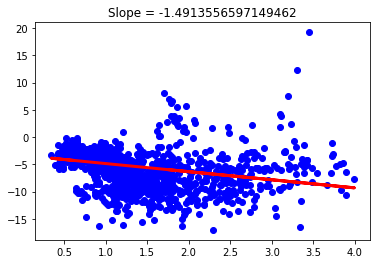

In [9]:
# Number of cylces
n_cycle = len(ds_ATL11['cycle'])

# Distance along track
dat = calc_dat(ds_ATL11)

# Loop over each cycle
for j in range(0, n_cycle - 1):
    for k in range(j+1, n_cycle):
        
        # Calculate observed delta height
        h0 = ds_ATL11['Height'][:,j]
        h0[h0 < 250] = np.nan # Naive ice shelf filter
        hf = ds_ATL11['Height'][:,k]
        dh = hf - h0 # Units m
        dh = dh * 100 # Units cm
        dat_1km, dh_1km = interpolate_1km(dat, dh)
    
        # Plot figure if we have data
        if np.count_nonzero(~np.isnan(dh)) != 0:

            # Calculate uncertainty (both sources)
            e0 = np.sqrt(ds_ATL11['Height_Sigma'][:,j]**2 + ds_ATL11['Height_Sigma_Systematic'][:,j]**2) # Total error of first height measurement 
            ef = np.sqrt(ds_ATL11['Height_Sigma'][:,k]**2 + ds_ATL11['Height_Sigma_Systematic'][:,k]**2) # Total error of second height measurement 
            e = np.sqrt(e0**2 + ef**2) # Total error of difference between second and third height measurement
            e = e * 100 # Units cm

            # Retrieve time of measurement
            base_time = pd.Series(pd.date_range('2018-01-01', periods=1, freq='D'))
            t0 = pd.Timedelta(np.nanmean(ds_ATL11['Time'][:,j]), unit='s') + base_time
            t0 = datetime.strptime(np.datetime_as_string(t0, unit='D')[0], '%Y-%m-%d')
            tf = pd.Timedelta(np.nanmean(ds_ATL11['Time'][:,k]), unit='s') + base_time
            tf = datetime.strptime(np.datetime_as_string(tf, unit='D')[0], '%Y-%m-%d')

            # Calculate M2 SMB
            M2_SMB = get_M2_smb(t0, tf).sum(dim='time')
            M2_SMB = M2_SMB.sel(lat=tgt_lat, lon=tgt_lon, method='nearest') / 10 # Units start at kg which is equivaent to mm. w.e. Transform to cm
            dat_1km, M2_SMB_1km = interpolate_1km(dat, M2_SMB)

            RF_ratio = get_RF_M2(tgt_lat, tgt_lon, tgt_x, tgt_y, M2_mean_annual_SMB, M2_RF)
            RF_SMB = RF_ratio * M2_SMB
            dat_1km, RF_SMB_1km = interpolate_1km(dat, RF_SMB)
            
            # Compute regression statistics
            x = RF_SMB_1km
            y = dh_1km
            non_nan_inds = ~np.isnan(y)
            x = x[non_nan_inds]
            y = y[non_nan_inds]
            non_nan_inds = ~np.isnan(x)
            x = x[non_nan_inds]
            y = y[non_nan_inds]
            lin_reg = stats.linregress(x, y)
            print("R^2 = " +str(lin_reg.rvalue**2))
            print("p = " + str(lin_reg.pvalue))
            print()

            ## Plot figure

            # IC2
            plt.figure(figsize=(20, 7))
            plt.plot(dat, dh, 'b--', linewidth=0.5)
            plt.plot(dat_1km, dh_1km, 'b', linewidth=2, label='ICESat-2 Delta Height [cm]')
            #plt.fill_between(dat, dh - e, dh + e, color='b', alpha=0.1)

            # M2
            plt.plot(dat, M2_SMB, 'k--', linewidth=0.5)
            plt.plot(dat_1km, M2_SMB_1km, 'k', label='MERRA-2 SMB [cm w.e.]', linewidth=2)

            # Random Forrest
            plt.plot(dat, RF_SMB, 'r--', linewidth=0.5)
            plt.plot(dat_1km, RF_SMB_1km, 'r', label='Statistical SMB [cm w.e.]', linewidth=2)

            # Settings
            plt.xlabel("Distance Along Track [km]", fontsize=16)
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.grid()
            plt.legend(fontsize=16)
            plt.title(str(tf)[0:10] + " - " + str(t0)[0:10] + ", R = " + str(lin_reg.rvalue) + ", p = " + str(lin_reg.pvalue) \
                      + ", Cycle " + str(j) + " - " + str(k) , fontsize=16)
            
            # Plot scatter
            plt.figure()
            plt.scatter(x, y, c='b')
            plt.plot(x, lin_reg.intercept + lin_reg.slope*x, 'r', label='fitted line', linewidth=3)
            plt.title("Slope = " + str(lin_reg.slope))


            

